In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, mean_squared_error, f1_score, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.cross_validation import StratifiedKFold, KFold
from collections import Counter
import pprint
import time
import sys
import pickle
import math

%matplotlib inline

In [2]:
def intersection(s1, s2):
    s = set(s2)
    return filter(lambda x: x in s, s1)

In [161]:
def gini(y):
    hist = Counter(y)
    return 1. - np.sum(np.array(hist.values()) / float(len(y)))**2

def mse(y):
    return np.var(y) * len(y)

class Node:
    def __init__(self, depth, max_depth, impurity, is_leaf=False):
        self.is_leaf = is_leaf
        self.depth = depth
        self.max_depth = max_depth
        self.impurity = impurity
        
    def stopping_criteria(self, X, y):
        if self.max_depth is not None and self.depth >= self.max_depth:
            return True
                
        if self.impurity == 'gini':        
            return np.unique(y).shape[0] == 1
        
    def get_answer(self, y):
        if self.impurity == 'gini':
            return Counter(y).most_common()[0][0]
        else:                
            return np.mean(y)
    
    def get_impurity_change(self, y, y_left, y_right):
        if self.impurity == 'gini':
            return gini(y) - gini(y_left) * len(y_left) / len(y) - gini(y_right) * len(y_right) / len(y)
        else:
            return mse(y) - mse(y_left) * len(y_left) / len(y) - mse(y_right) * len(y_right) / len(y)
        
    def get_predicate(self, X, y, table, indices):
        m = X.shape[1]
        
        best_feature = None
        best_threshold = None
        best_impurity = None
        best_index = None
    
        for feature in np.arange(m):
            if self.impurity == 'gini':
                hist_left = Counter([])
                hist_right = Counter(y[indices])
                            
                square_sum_left, square_sum_right = 0, np.sum(np.array(hist_right.values())**2)
            else:
                sum_left, sum_right = 0, np.sum(y[indices])                
            
            table_feature = intersection(table[feature], indices)
            
            n = len(table_feature)
            
            for ind, k in enumerate(table_feature[:-1]):

                if self.impurity == 'gini':
                    square_sum_left += 2 * hist_left[y[k]] + 1
                    square_sum_right -= 2 * hist_right[y[k]] - 1

                    hist_left[y[k]] += 1
                    hist_right[y[k]] -= 1

                    new_impurity = -float(square_sum_left) / (ind+1) - float(square_sum_right) / (n-ind-1)
                else:
                    sum_left += y[k]
                    sum_right -= y[k]
                    
                    new_impurity = -sum_left**2 / float(ind+1) - sum_right**2 / float(n-ind-1)

                if X[table_feature[ind+1], feature] > X[k, feature]:
                    
                    if best_feature is None or new_impurity < best_impurity:
                        threshold = (X[k, feature] + X[table_feature[ind+1], feature]) / 2.

                        best_feature = feature
                        best_threshold = threshold
                        best_impurity = new_impurity
                        best_index = ind+1                        
                
        if best_feature is not None:
            table_feature = intersection(table[best_feature], indices)

            best_left  = table_feature[:best_index]
            best_right = table_feature[best_index:]
                        
            self.var_importance = len(indices) * self.get_impurity_change(y[indices], y[best_left], y[best_right]) / X.shape[0]
        else:
            best_left  = None
            best_right = None        
                
        return best_feature, best_threshold, best_left, best_right
        
    def fit(self, X, y, table, indices):
        
        if self.stopping_criteria(X[indices], y[indices]):
            self.is_leaf = True
            self.answer = self.get_answer(y[indices])
            return
        
        #t = time.time()
        self.feature, self.threshold, left, right = self.get_predicate(X, y, table, indices)
        #print "Split: ", time.time() - t

        if self.feature is None:
            self.is_leaf = True
            self.answer = self.get_answer(y[indices])            
            return

        self.left = Node(self.depth + 1, max_depth=self.max_depth, impurity=self.impurity)
        self.left.fit(X, y, table, left)

        self.right = Node(self.depth + 1, max_depth=self.max_depth, impurity=self.impurity)
        self.right.fit(X, y, table, right)
    
    def predict(self, X):
        if self.is_leaf:
            return self.answer
        else:
            if X[self.feature] <= self.threshold:
                return self.left.predict(X)
            else:
                return self.right.predict(X)
            
    def get_feature_scores(self):
        if self.is_leaf:
            return Counter([])
        
        left_scores = self.left.get_feature_scores()
        right_scores = self.right.get_feature_scores()
        
        scores = left_scores + right_scores
        scores[self.feature] += self.var_importance
        
        return scores
        
class CART:
    def __init__(self, impurity='gini', max_depth=None):
        if impurity not in ['gini', 'mse']:
            raise ValueError("Only gini and mse criteria are supported")
        self.impurity = impurity
        self.max_depth = max_depth
    
    def fit(self, X, y):
        
        table = X.argsort(axis=0).T
        indices = np.arange(X.shape[0])
        
        self.root = Node(0, max_depth=self.max_depth, impurity=self.impurity)                
        self.root.fit(X, y, table, indices)
        return self
        
    def predict(self, X):
        answer = []
        for x in X:
            answer.append(self.root.predict(x))
        return np.array(answer)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
    
    def get_feature_scores(self):
        return self.root.get_feature_scores()        

In [4]:
def shuffle(df, train_percent=0.8):
    X = np.copy(df.values)
    np.random.shuffle(X)
    
    X, y = X[:, :-1], X[:, -1]
    
    train_size = int(X.shape[0] * train_percent)
    
    X_train, y_train = X[:train_size, :], y[:train_size]
    X_test, y_test = X[train_size:, :], y[train_size:]
    
    return X_train, y_train, X_test, y_test

In [5]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [165]:
class RandomForest:
    def __init__(self, n_estimators=10, max_depth=10, poi=1.0, pof=1.0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.poi = poi
        self.pof = pof
            
    def fit(self, X, y):
        
        print "Fitting random forest with {} estimators".format(self.n_estimators)
        
        self.estimators = []
        self.estimators_features = []
        
        self.oob_score = []
           
        #np.random.seed(1543*1543)
        np.random.seed(1)
    
        i = 0
        for _ in xrange(self.n_estimators):
            
            i += 1
            print "Fitting estimator number {}".format(i)
            
            n, m = X.shape
            items    = np.sort(np.random.choice(n, n * self.poi))
            features = np.sort(np.random.choice(m, m * self.pof, replace=False))
            
            mask = np.ones((X.shape[0],), dtype=bool)
            mask[items] = 0
            
            #estimator = CART(max_depth=self.max_depth)
            estimator = CART()
            #estimator = DecisionTreeClassifier(max_depth=self.max_depth)
            #estimator = DecisionTreeClassifier()
            estimator.fit(X[:, features][items, :], y[items])
            
            self.estimators.append(estimator)
            self.estimators_features.append(features)
                        
            self.oob_score.append(estimator.score(X[:, features][mask, :], y[mask]))
        #print "OOB score: {}".format(np.mean(self.oob_score))
        print "OOB score: {}".format(np.mean(self.oob_score))
    
    def predict(self, X):
        answer = 0
        
        prob = [Counter([])] * X.shape[0]
        
        for e, f, s in zip(self.estimators, self.estimators_features, self.oob_score):
            p = e.predict(X[:, f])
            answer += p

            for i, a in enumerate(p):
                prob[i][a] += 1
                
        answer /= self.n_estimators
        answer = np.sign(answer)
        #answer[answer == -1] = 0
                    
        #pprint.pprint(map(lambda c: np.array(c.values()) / float(X.shape[0] * self.n_estimators), prob))
        
        return answer
    
    def score(self, X, y):
        pred = self.predict(X)        
        return np.mean(pred == y)
    
    def get_feature_scores(self):
        feature_scores = Counter([])
        for e, ef in zip(self.estimators, self.estimators_features):
            scores = e.get_feature_scores()
            for f, s in scores.items():
                feature_scores[ef[f]] += s            
        return feature_scores

In [7]:
def binarize(y):
    return np.array([-1 if x < 0.0 else 1 for x in y])

In [205]:
class GradientBoosting:
    def __init__(self, n_estimators=10, max_depth=5, mu=0.1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth        
        self.mu = mu
    
    def loss(self, y_true, y_pred):
        return log_loss((y_true+1) / 2., (y_pred + 1) / 2.)
    
    def get_learning_rate(self, X, y, estimator):
        
        old = np.array(self.predict(X))
        new = np.array(estimator.predict(X))

        best_b = self.mu
        best_loss = float("+inf")
        
        b = 0.1
        while b <= 10.0:
            p = old + b * self.mu * new
            p = binarize(p)
            
            loss = self.loss(y, p)
            
            if loss <= best_loss:                
                best_b = b
                best_loss = loss
                
            b += 0.1
        
        b = 10.0
        while b <= 100.0:
            p = old + b * self.mu * new
            p = binarize(p)
            
            loss = self.loss(y, p)
            if loss <= best_loss:
                
                best_b = b
                best_loss = loss
                
            b += 1.0
        
        return self.mu * b    
    
    def fit(self, X, y):
        
        print "Fitting gradient boosting with {} estimators".format(self.n_estimators)
        
        self.estimators = []
        self.weigths = []
        
        estimator = CART(max_depth=1, impurity='mse')
        estimator.fit(X, y)
        
        #sk_estimator = DecisionTreeClassifier(max_depth=1)
        #sk_estimator = DecisionTreeRegressor(max_depth=1)
        #sk_estimator.fit(X, y)
        #print "SK LOG LOSS: ", log_loss(y, sk_estimator.predict(X))
        
        #h = estimator.predict(X)
        
        #print "LOG LOSS: ", log_loss(y, estimator.predict(X))
        
        self.estimators.append(estimator)
        #self.estimators.append(sk_estimator)
        self.weigths.append(1.)
        
        n = X.shape[0]
        
        old_loss = 0
        
        depth = self.max_depth        
        for i in xrange(self.n_estimators):
                    
            print "Fitting estimator number {}".format(i+1)
            
            h = self.predict(X)
            
            g = (y+1)/2. - sigmoid((h+1)/2.)
             
            loss = self.loss(y_true=y, y_pred=binarize(h))
            print "Score: ", np.mean(y == binarize(h))
            #loss = self.loss(y, h)        
            print "Loss: {}\ndiff: {}".format(loss, loss - old_loss)                    
                        
            old_loss = loss            
                    
            estimator = CART(max_depth=depth, impurity='mse')
            estimator.fit(X, g)
            
            sk_estimator = DecisionTreeRegressor(max_depth=depth)
            sk_estimator.fit(X, g)
            
            self.estimators.append(estimator)
            #self.estimators.append(sk_estimator)
            
            print "MY MSE: ", mean_squared_error(g, estimator.predict(X))
            print "SK MSE: ", mean_squared_error(g, sk_estimator.predict(X))
            
            b = self.get_learning_rate(X, y, estimator)
            #b = self.get_learning_rate(X, y, sk_estimator)
            self.weigths.append(b)

    def predict(self, X):
        answer = 0
        for b, a in zip(self.weigths, self.estimators):            
            answer += b * a.predict(X)
        return answer
    
    def score(self, X, y):
        pred = self.predict(X)
        return np.mean(np.sign(pred) == y)
    
    def get_feature_scores(self):        
        feature_scores = Counter([])
        for w, e in zip(self.weights, self.estimators):
            scores = e.get_feature_scores()
            for k in scores.keys():
                scores[k] *= w
            feature_scores += scores
        return feature_scores

In [121]:
class VotingClassifier:
    def __init__(self, estimators, weigths=None):
        self.estimators = estimators
        self.weights = weigths
    
    def fit(self, X, y):
        if self.weights is not None:
            return
        
        self.weights = np.zeros((len(self.estimators),))
        
        predicts = np.concatenate(map(lambda e: [e.predict(X)], self.estimators)).T
                
        alpha = 0.0001
        
        eps = 0.01
        
        print "Fitting voting classifier"
        
        h = np.dot(predicts, self.weights)
        old_err = float('+inf')
        err = log_loss((y+1)/2, (binarize(h)+1)/2)
        i = 0
        while abs(err - old_err) > eps:
            
            grad = np.dot(predicts.T, sigmoid(h) - y) / X.shape[0]
            self.weights -= alpha * grad
            
            h = np.dot(predicts, self.weights)
            old_err = err
            err = log_loss((y+1)/2, (binarize(h)+1)/2)
    
    def predict(self, X):
        answer = 0
        for weight, estimator in zip(self.weights, self.estimators):
            p = estimator.predict(X)            
            answer += weight * p
        answer = np.sign(answer / len(self.estimators))
        return answer
    
    def score(self, X, y):
        pred = self.predict(X)
        return np.mean(pred == y)
    
    def get_feature_scores(self):
        feature_scores = Counter([])
        for w, e in zip(self.weights, self.estimators):
            scores = e.get_feature_scores()
            for k in scores.keys():
                scores[k] *= w
            feature_scores += scores
        return feature_scores

In [241]:
def CFS(X, y):    
    r = np.corrcoef(X, y.reshape(-1, 1), rowvar=0)
    ry = r[:, -1]
    r = r[:-1, :-1]
    
    best_all_score = None
    best_features = None
    all_features = []
    
    features = set([])
    
    ysum = 0.0
    pairsum = 0.0
    d = 0
    
    features_scores = Counter([])
    for i in xrange(X.shape[1]):
        best_score = None
        for f in xrange(X.shape[1]):
            if f not in features:
                score = (ysum + ry[f]) / math.sqrt(d + 1 + 2 * (pairsum + np.sum(r[f, list(features)])))
                if best_score is None or score > best_score:
                    best_score = score
                    best_feature = f
        
        d += 1
        pairsum += 2 * np.sum(r[best_feature, list(features)])
        ysum += ry[best_feature]
        
        features.add(best_feature)
        all_features.append((best_feature, best_score))
                    
        if best_all_score < best_score:
            best_all_score = best_score
            best_features = features
            
    return best_features, best_all_score, all_features

In [263]:
def J(X, y, feature_set, model):
    f1 = []
    for train_index, test_index in KFold(y.shape[0], n_folds=3, shuffle=True):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
                
        model.fit(X_train, y_train)        
        p = model.predict(X_test)        
        
        f1.append(f1_score(np.array((y_test+1)/2, dtype=int), np.array((p+1)/2, dtype=int)))
    return np.mean(f1)

def forward_selection(X, y, n, model):
    features = []
    scores = []
    
    best_features = None
    best_all_score = None
    
    current_features = set([])
    
    for j in xrange(X.shape[1]):
        best_score = None
        best_feature = None
        
        t = time.time()
        
        for f in xrange(X.shape[1]): # Find best feature
            if f in current_features:
                continue

            #print "Trying feature number ", f
                
            current_set = current_features | set([f])
            score = J(X[:, list(current_set)], y, current_set, model)
            if best_score is None or score > best_score:
                best_score = score
                best_feature = f
        
        features.append(best_feature)
        scores.append(best_score)
        
        print best_score
        
        current_features.add(best_feature) # Add new feature

#         if best_all_score is not None and best_score >= eta * best_all_score:
#             return best_features
        
        if best_all_score is None or best_all_score < best_score:
            best_all_score = best_score
            best_features = current_features
            best_j = j
            
        print "[Iteration number {}]".format(j)
        print "Best features so far: {}".format(best_features)
        print "Time elapsed on iteration: {}".format(time.time() - t)
        sys.stdout.flush()
        
        #if j - best_j >= n:
            #return best_features
    
    return best_features, best_all_score, features, scores

In [264]:
model = VotingClassifier([
        ('gb', GradientBoostingClassifier(n_estimators=50, learning_rate=0.03, max_depth=3)),
        ('rf', RandomForestClassifier(n_estimators=50))
    ], voting='soft')

t = time.time()
wrapper_best_features, wrapper_best_score, wrapper_all_features, wrapper_all_scores = forward_selection(spam_X_train, spam_y_train, 2, model)
print time.time() - t

0.849393279131
[Iteration number 0]
Best features so far: set([48])
Time elapsed on iteration: 115.462303162
0.880265755608
[Iteration number 1]
Best features so far: set([48, 42])
Time elapsed on iteration: 100.477928162
0.904757764959
[Iteration number 2]
Best features so far: set([48, 42, 70])
Time elapsed on iteration: 119.885170937
0.923801101009
[Iteration number 3]
Best features so far: set([48, 41, 42, 70])
Time elapsed on iteration: 124.949954987
0.932619867349
[Iteration number 4]
Best features so far: set([48, 41, 42, 101, 70])
Time elapsed on iteration: 135.90101099
0.948181877008
[Iteration number 5]
Best features so far: set([101, 70, 41, 42, 15, 48])
Time elapsed on iteration: 159.726443052
0.952783705844
[Iteration number 6]
Best features so far: set([101, 70, 41, 42, 15, 48, 53])
Time elapsed on iteration: 161.849126101
0.956596655402
[Iteration number 7]
Best features so far: set([101, 70, 41, 42, 15, 48, 53, 9])
Time elapsed on iteration: 160.080096006
0.958655563789

In [265]:
tosave = (wrapper_best_features, wrapper_best_score, wrapper_all_features, wrapper_all_scores)
wrapper_file = open('wrapper.pkl', 'wb')
pickle.dump(tosave, wrapper_file)
wrapper_file.close()

In [ ]:
model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3)
model.fit(spam_X_train[:, list(best_features)], spam_y_train)

model_pred = model.predict(spam_X_test[:, list(best_features)])

print f1_score(np.array((spam_y_test+1)/2, dtype=int), np.array((model_pred+1)/2, dtype=int))

In [245]:
embedded_features, embedded_scores = zip(*voting_clf.get_feature_scores().most_common())

In [274]:
print embedded_features

embedded_f1_scores = []

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    embed_clf = VotingClassifier([
        ('gb', GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, max_depth=3)),
        ('rf', RandomForestClassifier(n_estimators=300, max_features=1.0))
    ], voting='soft')
    features = sorted(embedded_features[:i])
    embed_clf.fit(spam_X_train[:, features], spam_y_train)
    pred = embed_clf.predict(spam_X_test[:, features])
    embedded_f1_scores.append(f1_score(np.array((spam_y_test+1)/2, dtype=int), np.array((pred+1)/2, dtype=int)))

(48, 70, 101, 49, 8, 71, 10, 9, 29, 35, 52, 53, 4, 32, 75, 41, 17, 56, 19, 14, 76, 73, 47, 31, 3, 15, 43, 55, 16, 42, 45, 50, 83, 80, 33, 78, 51, 72, 87, 38, 100, 37, 11, 39, 79, 20, 24, 30, 22, 54, 27, 21, 44, 12, 13, 74, 96, 82, 62, 0, 85, 46, 28, 23, 18, 61, 59, 81, 88, 95, 36, 6, 89, 90, 7, 93, 92, 84, 40, 86, 25, 26, 5, 91, 63, 57, 99, 1, 2)


In [246]:
cfs_features, cfs_all_score, cfs_all_features = CFS(spam_X_train, spam_y_train)
_, cfs_scores = zip(*cfs_all_features)

In [278]:
filter_f1_scores = []

filter_features = map(lambda x: x[0], cfs_all_features)

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    filter_clf = VotingClassifier([
        ('gb', GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, max_depth=3)),
        ('rf', RandomForestClassifier(n_estimators=300, max_features=1.0))
    ], voting='soft')
    features = sorted(filter_features[:i])
    filter_clf.fit(spam_X_train[:, features], spam_y_train)
    pred = filter_clf.predict(spam_X_test[:, features])
    filter_f1_scores.append(f1_score(np.array((spam_y_test+1)/2, dtype=int), np.array((pred+1)/2, dtype=int)))

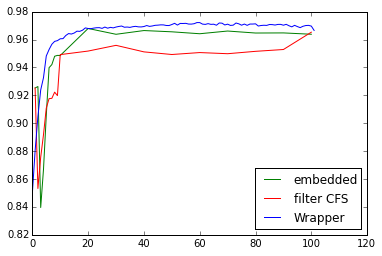

In [279]:
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], embedded_f1_scores, label='embedded', color='g')
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], filter_f1_scores, label='filter CFS', color='r')
plt.plot(wrapper_all_scores, label='Wrapper', color='b')
plt.legend(loc=4)
plt.show()

In [ ]:
times = []
with open('wrapper.time', 'r') as f:
    times = map(float, f.readlines())
    
plt.plot(times)

In [ ]:
df = pd.read_csv('iris.data', delimiter=',')[50:]
df.head()

In [ ]:
classes = {
    "Iris-setosa": 0,
    "Iris-versicolor": 1,
    "Iris-virginica": 0
}

df["num_class"] = df["class"].apply(lambda s: classes[s])

In [ ]:
df.describe()

In [ ]:
X_train, y_train, X_test, y_test = shuffle(df.drop("class", axis=1), train_percent=0.6)
print "Train size: {}; Test size: {};".format(X_train.shape[0], X_test.shape[0])

In [ ]:
cart_clf = CART(max_depth=10, impurity='mse')
cart_clf.fit(X_train, y_train)

In [ ]:
pred = cart_clf.predict(X_test)

In [ ]:
#print "Log loss: {}".format(log_loss(y_test, pred))
#print "Accuracy: {}".format(cart_clf.score(X_test, y_test))
print "MSE: {}".format(mean_squared_error(y_test, pred))

In [ ]:
#tree = DecisionTreeClassifier(max_depth=10, random_state=1)
tree = DecisionTreeRegressor(max_depth=10, random_state=1)
tree.fit(X_train, y_train)

In [ ]:
pr = tree.predict(X_test)

In [ ]:
#print "Log loss: {}".format(log_loss(y_test, sigmoid(pr)))
#print "Log loss: {}".format(log_loss(y_test, pr))
#print "Accuracy: {}".format(tree.score(X_test, y_test))
print "MSE: {}".format(mean_squared_error(y_test, pr))

In [ ]:
y_train[y_train == 0] = -1
y_test[y_test == 0] = -1

In [ ]:
forest_clf_1 = RandomForest(n_estimators=100, max_depth=10)
forest_clf_1.fit(X_train, y_train)

In [ ]:
forest_clf_1.score(X_test, y_test)

In [ ]:
forest = RandomForestClassifier(n_estimators=100, max_depth=10, max_features=1.0)
forest.fit(X_train, y_train)

In [ ]:
forest.score(X_test, y_test)

In [ ]:
grad_clf_1 = GradientBoosting(n_estimators=100, mu=0.1)
grad_clf_1.fit(X_train, y_train)

In [ ]:
grad_clf_1.score(X_test, y_test)

In [ ]:
grad = GradientBoostingClassifier(n_estimators=100, max_depth=5)
#grad = GradientBoostingRegressor(n_estimators=100, max_depth=5)
grad.fit(X_train, y_train)

In [ ]:
print log_loss(y_test, grad.predict(X_test))
#grad.score(X_test, y_test)

In [11]:
spam_train_df = pd.read_csv('spam.train.txt', header=None, delimiter=" ")
spam_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,1,0.349723,0.658872,0.341822,0.369098,0.448115,0.327417,0.517556,0.393646,0.430504,...,0.470654,0.410545,0.590262,0.450158,0.443301,0.467284,0.438850,0.413235,0.433625,0.575691
1,1,0.320356,0.214419,0.796892,0.283771,0.429499,0.336705,0.209530,0.411694,0.620735,...,0.470654,0.410545,0.454687,0.450158,0.443301,0.467284,0.438850,0.413235,0.433625,0.354707
2,1,0.575150,0.658872,0.341822,0.541797,0.430258,0.575468,0.509843,0.518629,0.383852,...,0.470654,0.410545,0.454687,0.450158,0.443301,0.467284,0.992203,0.768557,0.433625,0.391791
3,1,0.349723,0.658872,0.341822,0.440102,0.455950,0.327417,0.560001,0.398133,0.376336,...,0.470654,0.410545,0.607055,0.450158,0.443301,0.467284,0.438850,0.413235,0.433625,0.550478
4,1,0.320356,0.658872,0.341822,0.385197,0.437169,0.709301,0.419971,0.288835,0.382394,...,0.470654,0.410545,0.454687,0.450158,0.443301,0.467284,0.438850,0.413235,0.433625,0.741449


In [12]:
spam_X_train = np.copy(spam_train_df.values)
np.random.shuffle(spam_X_train)
spam_X_train, spam_y_train = spam_X_train[:, 1:], spam_X_train[:, 0]

In [13]:
spam_test_df = pd.read_csv('spam.test.txt', header=None, delimiter=" ")
spam_test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,1,0.445622,0.632602,0.368683,0.728974,0.479510,0.471833,0.571882,0.579280,0.604702,...,0.462762,0.448051,0.446374,0.424879,0.472828,0.450815,0.427943,0.416184,0.446429,0.667609
1,1,0.296747,0.632602,0.368683,0.330429,0.374055,0.451231,0.249144,0.431370,0.344248,...,0.462762,0.448051,0.916790,0.424879,0.472828,0.368804,0.464272,0.400264,0.547989,0.580435
2,1,0.296747,0.632602,0.368683,0.309466,0.392561,0.458103,0.289492,0.595944,0.574234,...,0.462762,0.448051,0.798868,0.424879,0.472828,0.368804,0.472316,0.415417,0.446429,0.781863
3,1,0.296747,0.184437,0.831801,0.239714,0.494042,0.716275,0.295862,0.349747,0.434139,...,0.462762,0.448051,0.446374,0.424879,0.472828,0.368804,0.427943,0.854188,0.543903,0.562639
4,1,0.368046,0.632602,0.368683,0.280957,0.380190,0.445567,0.339384,0.534049,0.522703,...,0.462762,0.448051,0.446374,0.533793,0.472828,0.812761,0.473772,0.400264,0.446429,0.659760


In [14]:
spam_X_test = np.copy(spam_test_df.values)
np.random.shuffle(spam_X_test)
spam_X_test, spam_y_test = spam_X_test[:, 1:], spam_X_test[:, 0]

In [15]:
spam_y_train[spam_y_train == 0] = -1
spam_y_test[spam_y_test == 0] = -1

In [23]:
forest_clf = RandomForest(n_estimators=300, poi=1.0, pof=1.0)
forest_clf.fit(spam_X_train, spam_y_train)

Fitting random forest with 300 estimators
Fitting estimator number 1
Fitting estimator number 2
Fitting estimator number 3
Fitting estimator number 4
Fitting estimator number 5
Fitting estimator number 6
Fitting estimator number 7
Fitting estimator number 8
Fitting estimator number 9
Fitting estimator number 10
Fitting estimator number 11
Fitting estimator number 12
Fitting estimator number 13
Fitting estimator number 14
Fitting estimator number 15
Fitting estimator number 16
Fitting estimator number 17
Fitting estimator number 18
Fitting estimator number 19
Fitting estimator number 20
Fitting estimator number 21
Fitting estimator number 22
Fitting estimator number 23
Fitting estimator number 24
Fitting estimator number 25
Fitting estimator number 26
Fitting estimator number 27
Fitting estimator number 28
Fitting estimator number 29
Fitting estimator number 30
Fitting estimator number 31
Fitting estimator number 32
Fitting estimator number 33
Fitting estimator number 34
Fitting estimat

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [24]:
s = 0

forest_loss = []
forest_f1 = []

for e in forest_clf.estimators:
    pr = e.predict(spam_X_test)
    s += pr
    p = np.sign(s)
    forest_loss.append(log_loss(spam_y_test, p))    
    forest_f1.append(f1_score(np.array((spam_y_test+1)/2, dtype=int),
                              np.array((p+1)/2, dtype=int)))

forest_sk_loss = []
forest_sk_f1 = []

forest_tree = RandomForestClassifier(random_state=1, max_features=forest_clf.pof, warm_start=True)
for i in xrange(3, forest_clf.n_estimators):
    print i
    forest_tree.set_params(n_estimators=i)
    forest_tree.fit(spam_X_train, spam_y_train)
    p = forest_tree.predict(spam_X_test)    
    
    forest_sk_loss.append(log_loss(spam_y_test, p))
    forest_sk_f1.append(f1_score(np.array((spam_y_test+1)/2, dtype=int), 
                                 np.array((p+1)/2, dtype=int)))

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278


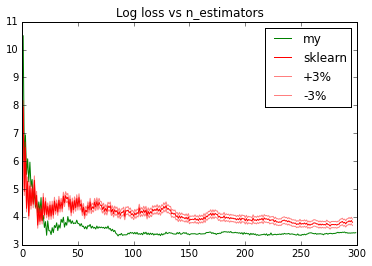

In [25]:
plt.figure()
plt.plot(forest_loss, label='my', color='g')

plt.plot(forest_sk_loss, label='sklearn', color='r')
plt.plot(np.array(forest_sk_loss) * 1.03, label='+3%', color='r', alpha=0.5)
plt.plot(np.array(forest_sk_loss) * 0.97, label='-3%', color='r', alpha=0.5)
plt.legend()
plt.title("Log loss vs n_estimators")
plt.show()

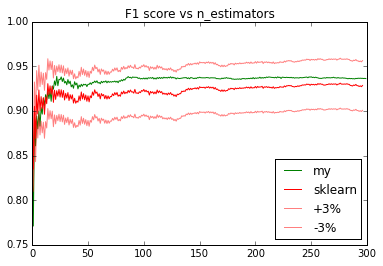

In [26]:
plt.figure()
plt.plot(forest_f1, label='my', color='g')

plt.plot(forest_sk_f1, label='sklearn', color='r')
plt.plot(np.array(forest_sk_f1) * 1.03, label='+3%', color='r', alpha=0.5)
plt.plot(np.array(forest_sk_f1) * 0.97, label='-3%', color='r', alpha=0.5)
plt.legend(loc=4)
plt.title("F1 score vs n_estimators")
plt.show()

In [27]:
forest_pred = forest_clf.predict(spam_X_test)

print "score: ", forest_clf.score(spam_X_test, spam_y_test)

p, r, f, _ = precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int),
                                             np.array((forest_pred+1)/2, dtype=int))
print "precision = ", p.mean()
print "recall = ", r.mean()
print "f1 = ", f.mean()

score:  0.90015910899
precision =  0.836802001648
recall =  0.880389379795
f1 =  0.855529986291


In [ ]:
forest_tree_pred = forest_tree.predict(spam_X_test)
p, r, f, _ = precision_recall_fscore_support(spam_y_test, forest_tree_pred)

#print "score: ", tree.score(spam_X_test, spam_y_test)

print "precision = ", p.mean()
print "recall = ", r.mean()
print "f1 = ", f.mean()

In [111]:
grad_clf = GradientBoosting(n_estimators=300, max_depth=3, mu=0.01)
grad_clf.fit(spam_X_train, spam_y_train)

Fitting gradient boosting with 300 estimators
Fitting estimator number 1
Score:  0.800930494854
Loss: 6.87575037273
diff: 6.87575037273
MY MSE:  0.0881430506584
SK MSE:  0.0881430506584
Fitting estimator number 2
Score:  0.800930494854
Loss: 6.87575037273
diff: 0.0
MY MSE:  0.0865412314261
SK MSE:  0.0865412314261
Fitting estimator number 3
Score:  0.891442267024
Loss: 3.74948429524
diff: -3.12626607749
MY MSE:  0.0800755874712
SK MSE:  0.0800755874712
Fitting estimator number 4
Score:  0.907232482729
Loss: 3.20411091852
diff: -0.545373376718
MY MSE:  0.0773138921242
SK MSE:  0.0773138921242
Fitting estimator number 5
Score:  0.902157056253
Loss: 3.37939832747
diff: 0.17528740895
MY MSE:  0.0724988967992
SK MSE:  0.0724988967992
Fitting estimator number 6
Score:  0.916960383477
Loss: 2.86810557301
diff: -0.511292754459
MY MSE:  0.0673754597067
SK MSE:  0.0673754597067
Fitting estimator number 7
Score:  0.916960383477
Loss: 2.86810422025
diff: -1.352765989e-06
MY MSE:  0.0617608177298
S

In [112]:
grad_clf.score(spam_X_train, spam_y_train)

0.98970816297758357

In [113]:
grad_pred = grad_clf.predict(spam_X_test)
grad_pred = np.sign(grad_pred)

print "score: ", grad_clf.score(spam_X_test, spam_y_test)

p, r, f, _ = precision_recall_fscore_support((spam_y_test+1)/2., (grad_pred+1)/2.)
print "precision = ", p.mean()
print "recall = ", r.mean()
print "f1 = ", f1_score(np.array((spam_y_test+1)/2, dtype=int),
                        np.array((grad_pred+1)/2, dtype=int))

print "Log loss = ", log_loss((spam_y_test+1)/2., (grad_pred+1)/2.)

score:  0.953758949881
precision =  0.923807808776
recall =  0.935031073661
f1 =  0.970888374131
Log loss =  1.59712487517


In [42]:
grad_tree = GradientBoostingClassifier(max_depth=3, n_estimators=300, learning_rate=0.01, random_state=1, presort=False)
grad_tree.fit(spam_X_train, spam_y_train)

GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort=False, random_state=1, subsample=1.0, verbose=0,
              warm_start=False)

In [43]:
grad_tree_pred = grad_tree.predict(spam_X_test)
p, r, f, _ = precision_recall_fscore_support((spam_y_test+1)/2., (grad_tree_pred+1)/2.)

print "score: ", grad_tree.score(spam_X_test, spam_y_test)

print "precision = ", p.mean()
print "recall = ", r.mean()
#print "f1 = ", f.mean()
print "f1 = ", f1_score((spam_y_test+1)/2, (grad_tree_pred+1)/2)

print "Log loss = ", log_loss((spam_y_test+1)/2., (grad_tree_pred+1)/2.)

score:  0.947195704057
precision =  0.916523674459
recall =  0.920635115754
f1 =  0.966851863412
Log loss =  1.8238158079


In [ ]:
s = 0

loss = []

for b, e in zip(grad_clf.weigths, grad_clf.estimators):
    s += b * e.predict(spam_X_test)    
    p = np.sign(s)
    loss.append(log_loss((spam_y_test+1)/2., (p+1)/2.))

plt.figure()
plt.plot(loss, label='my', color='g')

In [114]:
s = 0

loss = []
f1 = []

for b, e in zip(grad_clf.weigths, grad_clf.estimators):
    s += b * e.predict(spam_X_test)
    #p = sigmoid(s)
    p = np.sign(s)
    loss.append(log_loss((spam_y_test+1)/2., (p+1)/2.))
    f1.append(f1_score(spam_y_test, p))

grad_tree = GradientBoostingClassifier(max_depth=3, n_estimators=grad_clf.n_estimators, learning_rate=0.01, random_state=1)
grad_tree.fit(spam_X_train, spam_y_train)

stage_pred = grad_tree.staged_predict(spam_X_test)
sk_loss = map(lambda p: log_loss( (spam_y_test+1)/2., (p+1)/2. ), stage_pred)

stage_pred = grad_tree.staged_predict(spam_X_test) # Generator
sk_f1 = map(lambda p: f1_score(spam_y_test, p), stage_pred)

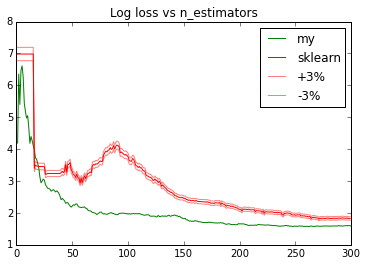

In [115]:
plt.figure()
plt.plot(loss, label='my', color='g')
 
plt.plot(sk_loss, label='sklearn', color='r')
plt.plot(np.array(sk_loss) * 1.03, label='+3%', color='r', alpha=0.5)
plt.plot(np.array(sk_loss) * 0.97, label='-3%', color='r', alpha=0.5)
plt.legend()
plt.title("Log loss vs n_estimators")
plt.show()

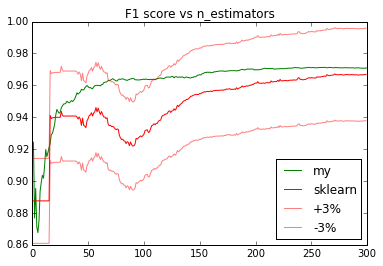

In [116]:
plt.figure()
plt.plot(f1, label='my', color='g')

plt.plot(sk_f1, label='sklearn', color='r')
plt.plot(np.array(sk_f1) * 1.03, label='+3%', color='r', alpha=0.5)
plt.plot(np.array(sk_f1) * 0.97, label='-3%', color='r', alpha=0.5)
plt.legend(loc=4)
plt.title("F1 score vs n_estimators")
plt.show()

In [122]:
voting_clf = VotingClassifier([forest_clf, grad_clf])
voting_clf.fit(spam_X_train, spam_y_train)
voting_pred = voting_clf.predict(spam_X_test)

print "Final F1 score: ", f1_score(np.array((spam_y_test+1)/2, dtype=int), np.array((voting_pred+1)/2, dtype=int))

Fitting voting classifier
Final F1 score:  0.971120716657


In [123]:
print voting_clf.weights

[ 0.00018359  0.0015128 ]


In [127]:
forest_file = open('forest.pkl', 'wb')
pickle.dump(forest_clf, forest_file)
forest_file.close()

In [128]:
grad_file = open('grad.pkl', 'wb')
pickle.dump(grad_clf, grad_file)
grad_file.close()

In [129]:
voting_file = open('voting.pkl', 'wb')
pickle.dump(voting_clf, voting_file)
voting_file.close()

In [134]:
voting_file = open('voting.pkl', 'rb')
ololo_clf = pickle.load(voting_file)
voting_file.close()

ololo_pred = ololo_clf.predict(spam_X_test)
f1_score(np.array((spam_y_test+1)/2, dtype=int), np.array((ololo_pred+1)/2, dtype=int))

0.97112071665726996

In [197]:
def foo(node):
    if node.is_leaf:
        return Counter([])

    left_scores = node.left.get_feature_scores()
    right_scores = node.right.get_feature_scores()

    #print left_scores, right_scores
    
    scores = left_scores + right_scores
    scores[node.feature] += 1. - np.sum(1. - node.var_importance)

    return scores

def bar(forest):
    feature_scores = Counter([])
    for e, ef in zip(forest.estimators, forest.estimators_features):
        scores = e.get_feature_scores()
        for f, s in scores.items():
            feature_scores[ef[f]] += s
        #scores = Counter(map(lambda (f, s): (ef[f], s), scores.items()))
        #feature_scores += scores
    return feature_scores

def baz(grad):
    feature_scores = Counter([])
    for w, e in zip(grad.weights, grad.estimators):
        scores = e.get_feature_scores()
        for k in scores.keys():
            scores[k] *= w
        feature_scores += scores
    return feature_scores

In [198]:
forest_clf.estimators[0].root.__class__.get_feature_scores = foo
forest_clf.__class__.get_feature_scores = bar
grad_clf.__class__.get_feature_scores = baz

In [154]:
dir(forest_clf.estimators[0].root)

['__doc__',
 '__init__',
 '__module__',
 'depth',
 'feature',
 'fit',
 'get_answer',
 'get_feature_scores',
 'get_impurity_change',
 'get_predicate',
 'impurity',
 'is_leaf',
 'left',
 'max_depth',
 'predict',
 'right',
 'stopping_criteria',
 'threshold',
 'var_importance']

In [280]:
len(grad_clf.weigths)

301

In [195]:
voting_clf.estimators[1].weights = grad_clf.weigths